In [1]:
import torch as t
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, ExponentialLR

### Model

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(3*32*32, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 3*32*32)
        x = self.relu(self.linear1(x))
        return x
net = Net()



### Hyperparams

In [3]:
num_epochs=100
after_every=100
loss_fn = nn.CrossEntropyLoss()
batch_size=128

In [19]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

mnist_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

### Training

In [5]:
def train_one_epoch(model, epoch_index, optimizer, train_dataset):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataset):
        # Every data instance is an input + label pair
        # data.shape=torch.Size([10, 1, 28, 28]) --> 10 images,labels
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.view(-1, 3*32*32))


        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % after_every == after_every-1:
            last_loss = running_loss / after_every # loss per after_every batches
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

### Evaluate

In [6]:
def test(model, loader):
  total=0
  correct=0
  model.eval()
  with t.no_grad():
      for data in loader:
          x, y = data
          output = model(x.view(-1, 3*32*32))
          for idx, i in enumerate(output):
              if t.argmax(i) == y[idx]:
                  correct +=1
              total +=1
  return round(correct/total, 3)*100

In [7]:
def train_model(model, epochs, train_dataset, test_dataset, optimizer, scheduler, LR_type):
  epoch_number = 0

  losses = []
  train_accuracy = []
  test_accuracy = []

  for epoch in range(epochs):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      model.train(True)
      avg_loss = train_one_epoch(model, epoch_number,optimizer,train_dataset)
      losses.append(avg_loss)

      # Train accuracy
      train_acc = test(model, train_dataset)
      train_accuracy.append(train_acc)

      # Test accuracy
      test_acc = test(model, test_dataset)
      test_accuracy.append(test_acc)

      if LR_type=='Plateau':
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(avg_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        print('lr {} -> {}'.format(before_lr, after_lr))

      elif LR_type!='None':
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print('lr {} -> {}'.format(before_lr, after_lr))

      print('Train accuracy {}:'.format(train_acc))
      print('Test accuracy {}:'.format(test_acc))
      epoch_number += 1
  return losses, train_accuracy, test_accuracy

In [8]:
import datetime as dt

def train_with_reg(starting_lr):
  losses_arr = []
  train_accuracy_arr = []
  test_accuracy_arr = []
  regularization_strengths = [0, 1e-7, 1e-5, 1e-3, 1e-1, 1.0]
  description = []

  # Different Reg strengths
  for regularization_strength in regularization_strengths:
    print('Reg Strength {}:'.format(regularization_strength))
    net_new = Net()
    optimizerr = t.optim.SGD(net_new.parameters(), lr=starting_lr, weight_decay=regularization_strength)
    scheduler = StepLR(optimizerr, 25, gamma=0.1)

    losses, train_accuracy, test_accuracy = train_model(net_new, num_epochs, train_loader, test_loader, optimizerr, scheduler, 'Step')

    losses_arr.append(losses)
    train_accuracy_arr.append(train_accuracy)
    test_accuracy_arr.append(test_accuracy)
    description.append('Starting LR:{}, L2Reg:{}'.format(starting_lr, regularization_strength))

    # save model
    ts_now = dt.datetime.now()
    unix_timestamp = dt.datetime.timestamp(ts_now)*1000
    model_save_name = str(unix_timestamp)
    path = F"{model_save_name}_L2Reg={regularization_strength}_bs{128}_e{num_epochs}_SGD_LRStep_.pt"
    t.save(net.state_dict(), path)

  return description, losses_arr, train_accuracy_arr, test_accuracy_arr


In [9]:
import csv
def save_to_csv(filename, description, losses_arr, train_acc_arr, test_acc_arr):
  # Create a CSV file and write data to it
  with open(filename+'.csv', 'w', newline='') as csvfile:
    for i, desc in enumerate(description):
      fieldnames = ['Description', 'epoch', 'train_loss', 'train_accuracy', 'test_accuracy']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()
      for epoch, (loss, train, test) in enumerate(zip(losses_arr[i], train_acc_arr[i], test_acc_arr[i]), 1):
          writer.writerow({'Description':description[i], 'epoch': epoch, 'train_loss': loss, 'train_accuracy': train, 'test_accuracy': test})


### Plotting- Starting LR=0.01
#### Reg strengths = [0, 1e-7, 1e-5, 1e-3, 1e-1, 1.0]

In [10]:
lr = 0.01
regularization_strengths = [0, 1e-7, 1e-5, 1e-3, 1e-1, 1.0]
description, losses_arr, train_accuracy_arr, test_accuracy_arr = train_with_reg(lr)
save_to_csv('Regularisation_Step', description, losses_arr, train_accuracy_arr, test_accuracy_arr)

Reg Strength 0:
EPOCH 1:
 batch 100 loss: 2.0270689606666563
 batch 200 loss: 1.8774386286735534
 batch 300 loss: 1.842015701532364
lr 0.01 -> 0.01
Train accuracy 39.0:
Test accuracy 38.6:
EPOCH 2:
 batch 100 loss: 1.794778413772583
 batch 200 loss: 1.7937125694751739
 batch 300 loss: 1.7653629744052888
lr 0.01 -> 0.01
Train accuracy 40.6:
Test accuracy 40.2:
EPOCH 3:
 batch 100 loss: 1.7599763810634612
 batch 200 loss: 1.7439782786369324
 batch 300 loss: 1.7555349218845366
lr 0.01 -> 0.01
Train accuracy 41.699999999999996:
Test accuracy 40.699999999999996:
EPOCH 4:
 batch 100 loss: 1.7358023405075074
 batch 200 loss: 1.7374082493782044
 batch 300 loss: 1.74824609041214
lr 0.01 -> 0.01
Train accuracy 42.1:
Test accuracy 41.099999999999994:
EPOCH 5:
 batch 100 loss: 1.7150224936008454
 batch 200 loss: 1.7189004707336426
 batch 300 loss: 1.7343584954738618
lr 0.01 -> 0.01
Train accuracy 42.8:
Test accuracy 41.4:
EPOCH 6:
 batch 100 loss: 1.7169190382957458
 batch 200 loss: 1.715080713033

In [11]:
import numpy as np
epochs_arr = np.arange(0, len(losses_arr[0]))

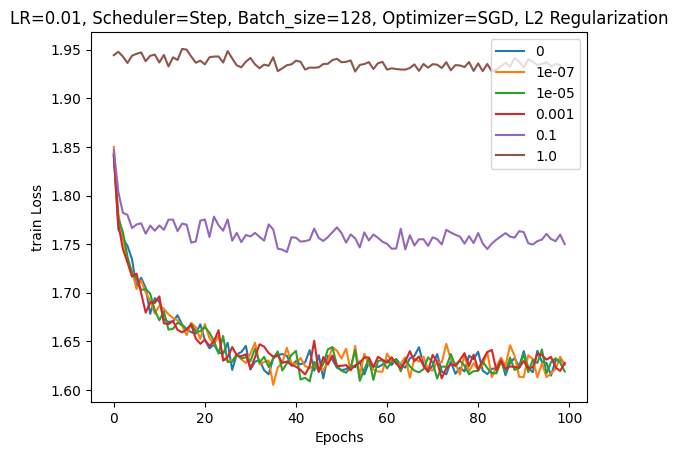

In [12]:
# Plot training loss
x = np.array(epochs_arr)
for i,train_loss in enumerate(losses_arr):
  ypoints = np.array(train_loss)
  plt.plot(x, ypoints, label = regularization_strengths[i])

plt.xlabel("Epochs")
plt.ylabel("train Loss")
plt.legend()
plt.title('LR=0.01, Scheduler=Step, Batch_size=128, Optimizer=SGD, L2 Regularization')
plt.show()

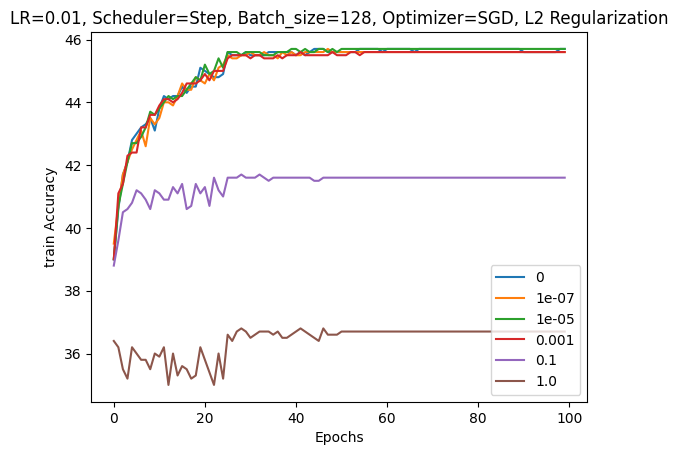

In [13]:
# Plot training accuracy
x = np.array(epochs_arr)
for i,train_acc in enumerate(train_accuracy_arr):
  ypoints = np.array(train_acc)
  plt.plot(x, ypoints, label = regularization_strengths[i])

plt.xlabel("Epochs")
plt.ylabel("train Accuracy")
plt.legend()
plt.title('LR=0.01, Scheduler=Step, Batch_size=128, Optimizer=SGD, L2 Regularization')
plt.show()

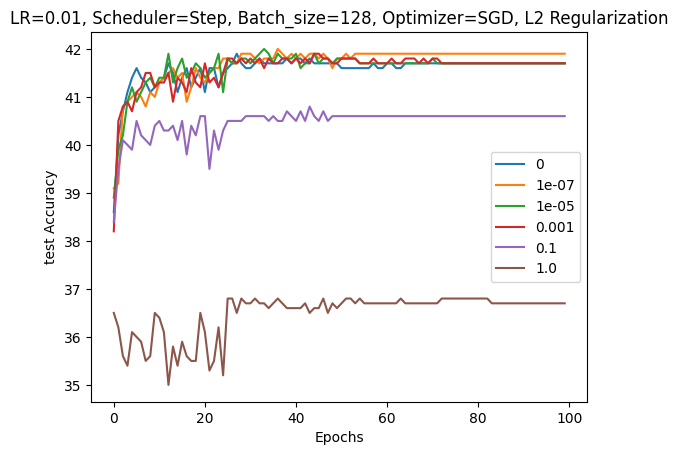

In [14]:
# Plot test accuracy
x = np.array(epochs_arr)
for i,test_acc in enumerate(test_accuracy_arr):
  ypoints = np.array(test_acc)
  plt.plot(x, ypoints, label = regularization_strengths[i])

plt.xlabel("Epochs")
plt.ylabel("test Accuracy")
plt.legend()
plt.title('LR=0.01, Scheduler=Step, Batch_size=128, Optimizer=SGD, L2 Regularization')
plt.show()

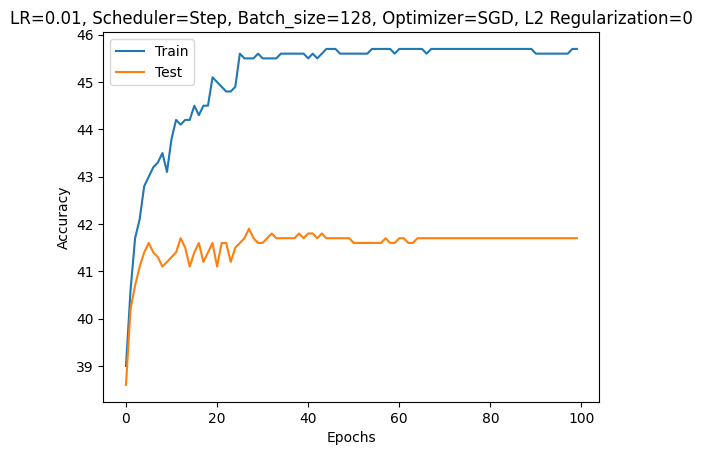

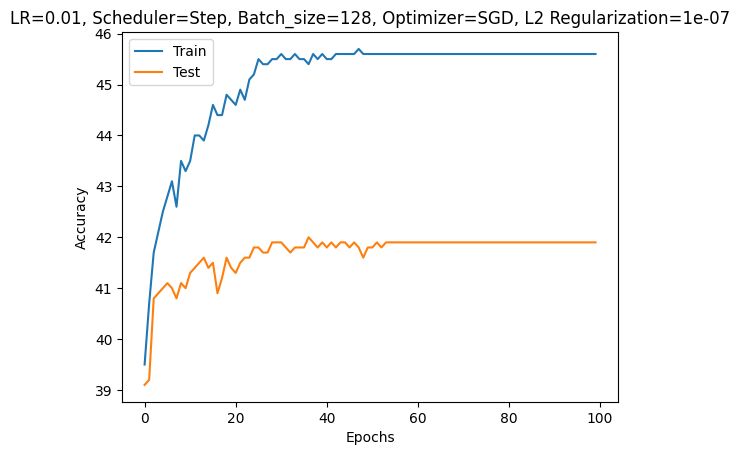

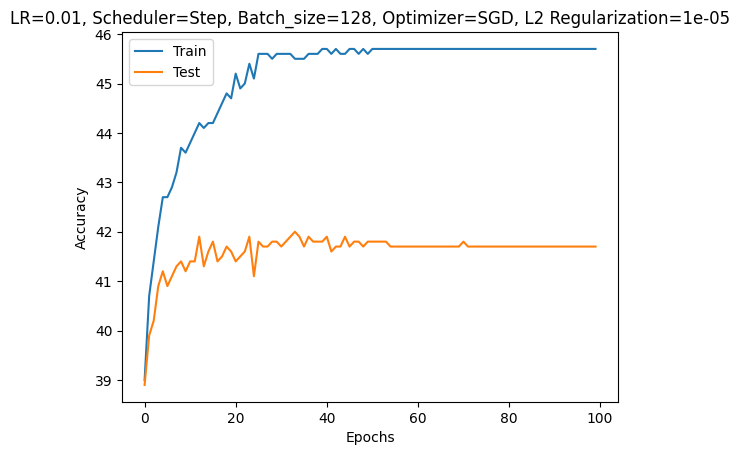

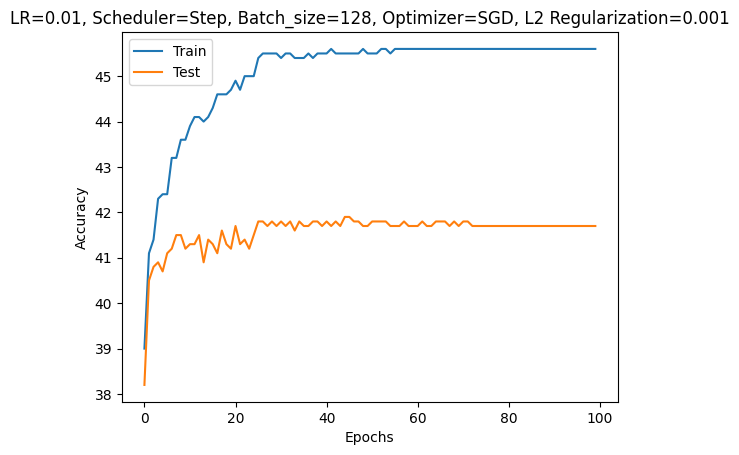

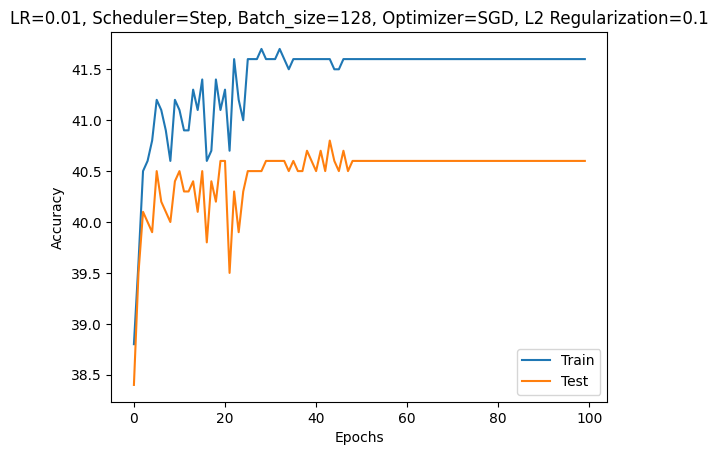

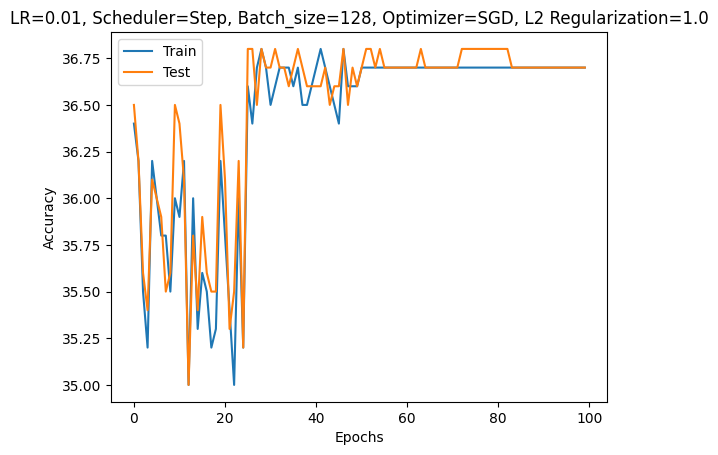

In [15]:
# Plot test and training accuracy
x = np.array(epochs_arr)
for i,reg in enumerate(regularization_strengths):
  ypoints_1 = np.array(train_accuracy_arr[i])
  ypoints_2 = np.array(test_accuracy_arr[i])
  plt.plot(x, ypoints_1, label = 'Train')
  plt.plot(x, ypoints_2, label = 'Test')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title(F'LR=0.01, Scheduler=Step, Batch_size=128, Optimizer=SGD, L2 Regularization={reg}')
  plt.show()

### Load model

In [24]:
model_save_name = '1695168105559.8071_Step_bs128_e30_SGD_ss10_gamma0.1_cifar'
path = F"{model_save_name}.pt"
net.load_state_dict(t.load(path))

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
test(net,test_loader)

In [ ]:
#hello kuch likhlo warna inactivity timeout de dega yeh